## This is the svm workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a linear support vector machine.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and includes code to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training an SVM classifier via gradient descent.

## Importing libraries and data setup

In [2]:
import numpy as np # for doing most of our calculations
import matplotlib.pyplot as plt# for plotting
from cs231n.data_utils import load_CIFAR10 # function to load the CIFAR-10 dataset.
import pdb

# Load matplotlib images inline
%matplotlib inline

# These are important for reloading any code you write in external .py files.
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
# Set the path to the CIFAR-10 data
cifar10_dir = r'C:\Users\李冠旻\HW2-code\cifar-10-batches-py' # You need to update this line
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


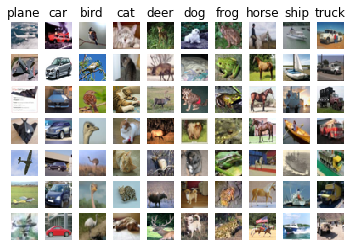

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Dev data shape: ', X_dev.shape)
print('Dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
Dev data shape:  (500, 32, 32, 3)
Dev labels shape:  (500,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


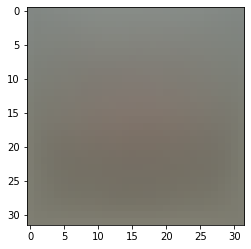

In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [8]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [9]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## Question:

(1) For the SVM, we perform mean-subtraction on the data.
However, for the KNN notebook, we did not.
Why?

## Answer:

(1) The goal of using SVM is trying to find the boundaries that keeps the maximum distances between each category area. If one of the numbers of the categories is too larger, it will pull the hyperplanes (boundries) closer to that area. Therefore, it 's common to normalize the data before performing the SVM.

## Training an SVM

The following cells will take you through building an SVM.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [10]:
from nndl.svm import SVM

In [11]:
# Declare an instance of the SVM class.  
# Weights are initialized to a random value.
# Note, to keep people's initial solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

svm = SVM(dims=[num_classes, num_features])

#### SVM loss

In [12]:
## Implement the loss function for in the SVM class(nndl/svm.py), svm.loss()

loss = svm.loss(X_train, y_train)
print('The training set loss is {}.'.format(loss))

# If you implemented the loss correctly, it should be 15569.98

The training set loss is 15569.97791541019.


#### SVM gradient

In [13]:
## Calculate the gradient of the SVM class.
# For convenience, we'll write one function that computes the loss
#   and gradient together. Please modify svm.loss_and_grad(X, y).
# You may copy and paste your loss code from svm.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = svm.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a numerical gradient check. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
svm.grad_check_sparse(X_dev, y_dev, grad)

numerical: -5.467881 analytic: -5.467881, relative error: 3.409970e-08
numerical: 6.874472 analytic: 6.874471, relative error: 1.517959e-08
numerical: 2.490579 analytic: 2.490578, relative error: 2.508737e-07
numerical: 14.228437 analytic: 14.228439, relative error: 4.791704e-08
numerical: 4.329881 analytic: 4.329881, relative error: 2.915563e-08
numerical: -13.631957 analytic: -13.631957, relative error: 8.702164e-09
numerical: 9.097727 analytic: 9.097727, relative error: 1.969652e-08
numerical: -14.280506 analytic: -14.280506, relative error: 4.241831e-09
numerical: 3.998392 analytic: 3.998393, relative error: 9.701286e-08
numerical: -15.175674 analytic: -15.175674, relative error: 1.546817e-08


## A vectorized version of SVM

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [14]:
import time

In [15]:
## Implement svm.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = svm.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = svm.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} / {}'.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output, i.e., differences on the order of 1e-12

Normal loss / grad_norm: 15870.653521122507 / 2068.3879036191333 computed in 0.09958553314208984s
Vectorized loss / grad: 15870.653521122515 / 2068.387903619134 computed in 0.0049974918365478516s
difference in loss / grad: -7.275957614183426e-12 / 7.134114375087961e-12


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

iteration 0 / 1500: loss 16557.38000190916
iteration 100 / 1500: loss 4701.089451272714
iteration 200 / 1500: loss 4017.3331379427877
iteration 300 / 1500: loss 3681.922647195363
iteration 400 / 1500: loss 2732.6164373988995
iteration 500 / 1500: loss 2786.6378424645045
iteration 600 / 1500: loss 2837.035784278267
iteration 700 / 1500: loss 2206.234868739933
iteration 800 / 1500: loss 2269.0388241169803
iteration 900 / 1500: loss 2543.23781538592
iteration 1000 / 1500: loss 2566.692135726826
iteration 1100 / 1500: loss 2182.068905905164
iteration 1200 / 1500: loss 1861.1182244250447
iteration 1300 / 1500: loss 1982.9013858528256
iteration 1400 / 1500: loss 1927.5204158582114
That took 6.292956352233887s


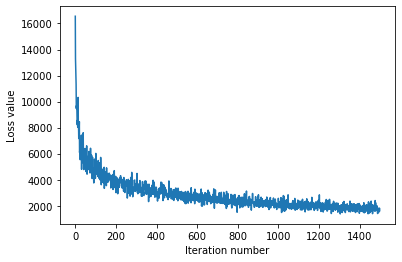

In [16]:
# Implement svm.train() by filling in the code to extract a batch of data
# and perform the gradient step.

tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=5e-4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained SVM on the validation data.

In [17]:
## Implement svm.predict() and use it to compute the training and testing error.

y_train_pred = svm.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = svm.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.28530612244897957
validation accuracy: 0.3


## Optimize the SVM

Note, to make things faster and simpler, we won't do k-fold cross-validation, but will only optimize the hyperparameters on the validation dataset (X_val, y_val).

In [18]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the SVM with different learning rates and evaluate on the
#     validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best VALIDATION accuracy corresponding to the best VALIDATION error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
#   Note: You do not need to modify SVM class for this section
# ================================================================ #
lr = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6 ]
for l in lr:
    num_incorrect = 0

    loss = svm.train(X=X_train, y=y_train, learning_rate = l)
    print(l)
    print(loss)

    y_pred = svm.predict(X_val)
    correct_preds = sum(y_pred == y_val)
    num_test = len (y_val)
    error =float(num_test - correct_preds) /num_test
    print(l)
    print(error)


#svm.train(X=X_train, y=y_train, learning_rate = l_b)
#y_b_pred = svm.predict_labels(X_test)
#correct_b_preds = sum(y_pred == y_test)
#num_test = len (y_test)
#b_error =float(num_test - correct_preds) /num_test

#print(b_error)
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


1e-06
[17772.83434183652, 15506.493815865457, 15677.432500812318, 17774.96479036961, 15154.871631707461, 15884.60171882329, 16311.848925549928, 15550.541697481145, 16324.54251575233, 15067.174427474025, 16261.426187920759, 18922.67199217205, 16702.550820128068, 14279.944789066329, 16142.325084949383, 13462.047488676822, 16759.067036200533, 16482.142047038695, 15852.152247027094, 16866.566572530937, 14628.118262528424, 15736.82178472309, 15651.005013004518, 15574.857171310861, 15367.715505513785, 16547.964296477032, 16719.35665140267, 16305.736728958795, 16730.019939674425, 16612.75331855169, 18760.242779477063, 16031.340677888114, 18410.70359619695, 14762.624391236068, 16150.281528373354, 15300.508605492254, 16677.945218523037, 17276.41027952342, 16138.83205329102, 15620.524632334525, 16802.153368025283, 16892.35358991228, 13676.779633339187, 15699.519759894027, 16864.535753266173, 16215.153891858821, 13954.331387502407, 17950.44112598197, 19526.899307534022, 15961.023110477587, 15500.

0.1
[15905.519267735028, 400244.7822890396, 234248.34968803966, 189940.83110871588, 225296.24426780513, 164310.22720748268, 232800.10966754163, 300302.6105704987, 203391.2892323615, 192589.16874500221, 237068.50288838445, 224720.91956567578, 187117.39627983212, 276019.14620421187, 275834.24347009807, 201780.12220292035, 199253.54319910315, 241098.02487087622, 176092.86969945193, 250459.43849201477, 231908.92716046685, 169356.3757919744, 228305.03380700786, 256793.63467185307, 202353.35324170857, 305509.97672279854, 187842.31384754524, 204658.4664994514, 119943.09199303224, 201774.7312010326, 199329.09063651995, 178834.51103388882, 104044.60025688824, 172798.7189563018, 174658.67364297024, 238022.1080742715, 263196.0504094083, 122521.37754626048, 160313.92728806415, 242401.70171331606, 269688.3668387197, 214895.06484344203, 162986.12736059737, 199624.2001019917, 232837.77091747097, 221249.63958054874, 141923.04794991738, 205516.69605907667, 391785.90264000476, 206050.80344710965, 228729

10000.0
[17653.728158819442, 32546360037.102814, 20796479128.997005, 13241571027.450634, 21049805732.924335, 24337780971.34035, 23941161658.489025, 20884205568.176205, 19909545711.182236, 37309011388.34599, 33571608731.122257, 19731237148.06337, 28129623907.15412, 21642255147.935978, 14802566394.807362, 10345034620.832304, 21743272719.601036, 32275912595.344902, 21416981916.805923, 24725420465.907745, 26101187608.460487, 27485200024.618526, 15194616878.145248, 20985607347.81219, 27791948150.775047, 16378275902.397764, 13327321909.023365, 23019661322.438477, 31084211072.61764, 30461173118.163105, 15507885459.06146, 21486200968.183952, 20582240500.295906, 25752785025.363194, 26110315519.817772, 19326667432.289837, 14477693552.696693, 22628535013.851986, 16828277640.178825, 28272384115.808174, 30755720625.28636, 29872740625.241264, 17515963302.6588, 16134507407.54188, 16319240957.174736, 17248060609.774223, 18700429745.371864, 23232045206.034958, 29335098828.290985, 26255323277.27556, 154

In [22]:
lr = 1
num_incorrect = 0

loss = svm.train(X=X_train, y=y_train, learning_rate = lr)
y_pred = svm.predict(X_test)
correct_preds = sum(y_pred == y_test)
num_test = len (y_test)
error =float(num_test - correct_preds) /num_test
print(error)

0.736
